## A/B Testing

Playground to experiment with A/B Testing statistics.

Resources:
- http://vanbelle.org/chapters/webchapter2.pdf
- https://towardsdatascience.com/required-sample-size-for-a-b-testing-6f6608dd330a
- https://towardsdatascience.com/understanding-power-analysis-in-ab-testing-14808e8a1554
- https://towardsdatascience.com/a-guide-for-selecting-an-appropriate-metric-for-your-a-b-test-9068cccb7fb
- https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/

In [39]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

### Designing a Test

When designing an A/B test, the following factors are considered:

- **Null Hypothesis (H0):** Design change has no effect on test outcome
- **Type I Error ($\alpha$):** Probability of rejecting the null hypothesis when it should *not* be rejected (false positive)
- **Type II Error ($\beta$):** Probability of not rejecting the null hypothesis when it should be rejected (false negative)
- **Power = 1 - $\beta$:** Probability of rejecting the null hypothesis when it should be rejected (true negative)
- **$\sigma^2_0$ and $\sigma^2_1$:** Variances under the null and alternative hypotheses (can be the same)
- **$\mu_0$ and $\mu_1$:** Means under the null and alternative hypotheses

For e-commerce applications, Type I Error means deploying a feature change when it actually has no positive effect on conversion rate. Type II Error means *not* deploying a feature change when it actually does have a positive effect on conversion.

### Sample Size

One of the first questions in designing the experiment is "how large should the sample size be"? Sticking with e-commerce applications, the following factors must be estimated to determine the minimum sample size:
1. **Conversion Rate**: Total number of orders divided by total number of unique visitors.
2. **Minimum Detectable Effect (MDE) Size**: The minimum effect size to make the experiment worthwhile. This is commonly some percent increase in conversion rate, which is connected to a measurable revenue increase. For instance, imagine an e-commerce company with 1 million unique visitors monthly and average basket size of $50. A 1% conversion rate increase would result in a significant $500k revenue increase. In contrast, a small company with only 10k unique visitors monthly would only see a $5k revenue increase which might not be worth the cost of the design change effort.
3. **Significance ($\alpha$):** Type I Error, or the probability threshold that the difference observed in the experiment is statistically significant. Commonly set to 5%. Can also be thought of as accepting a Type I Error (false positive) 5% of the time. 
4. **Power:** The higher the power, the lower the probability of making a Type II error. Commonly set to 80%. Can also be thought of as accepting a Type II Error (false negative) 20% of the time.
5. **Sample standard deviations:** Estimated from historical tests or data.

While many equations can be found for estimating minimum sample size, the one presented here is from the textbook [Statistical Rules of Thumb](http://vanbelle.org/chapters/webchapter2.pdf) by Gerald van Belle:
$$
n = {(\sigma_0^2 + \sigma_1^2)(z_{1-\alpha} + z_{1-\beta})^2 \over |\mu_1 - \mu_0|^2}
$$

where $z_{1-\alpha}$ is the z critical value for a given $\alpha$ (in a one-tailed test), $z_{1-\beta}$ is the z critical value for given a $\beta$. Note in a two-tailed test, $z_{1-\alpha}$ becomes $z_{1-\alpha/2}$.

### Parameter Tradeoffs

Selecting input parameters to determine sample size is all about tradeoffs. While the goal may be to minimize $\alpha$ (i.e. minimize Type I Errors) and maximize power (i.e. minimize Type II Errors), doing so requires more samples.
- Decrease $\alpha$ for higher confidence level --> requires more samples.
- Increase power for fewer false negatives --> requires more samples.
- Smaller sample variance --> requires fewer samples.
- Smaller delta --> requires more samples.

### Case Study: E-Commerce Website

Let's try an example from the towardsdatascience article:
- Assume the mean daily conversion rate for the past 6 months is 0.15.
- With the new feature, we expect to see a 3% absolute increase in conversion rate. Thus, for the conversion rate for the treatment group will be 0.18. 
- Assume the sample standard deviation for the two groups is 0.05.
- Assume alpha is 0.05 and power is 0.80 (typical values)

In [30]:
def min_sample_size(alpha, beta, one_tailed, sigma0, sigma1, mu0, mu1):
    """Return minumum sample size for A/B testing"""

    if one_tailed:
        # z-critical value, one-tailed
        z_alpha = scipy.stats.norm.ppf(1-alpha)
    else:
        # z-critical value, two-tailed
        z_alpha = scipy.stats.norm.ppf(1-alpha/2)

    z_beta = scipy.stats.norm.ppf(1-beta)

    var = sigma0**2 + sigma1**2
    delta = abs(mu1 - mu0)
    n = (var * (z_alpha + z_beta)**2) / delta**2
    return n
        

In [31]:
# Inputs
alpha = 0.05
power = 0.8
beta = 1 - power
one_tailed = True
sigma0 = 0.05
sigma1 = 0.05
conversion0 = 0.15
conversion1 = 0.18

n = min_sample_size(alpha, beta, one_tailed, sigma0, sigma1, conversion0, conversion1)
print(f'Min sample size: {n:.2f}')

Min sample size: 34.35


### Sensitivity Analysis: Alpha and Power

Let's look at how minimum sample size changes as alpha and power parameters are tweaked.

In [99]:
# Fixed
one_tailed = True
sigma0 = 0.05
sigma1 = 0.05
conversion0 = 0.15
conversion1 = 0.18

# Variable
alpha = np.linspace(0.01, 0.10, 40)
power = np.linspace(0.7, 0.9, 5)
beta = 1 - power

# Sample size 2D array
n = np.zeros((len(beta), len(alpha)))
for index, value in enumerate(beta):
    n[index, :] = [min_sample_size(a, value, one_tailed, sigma0, sigma1, conversion0, conversion1) for a in alpha]


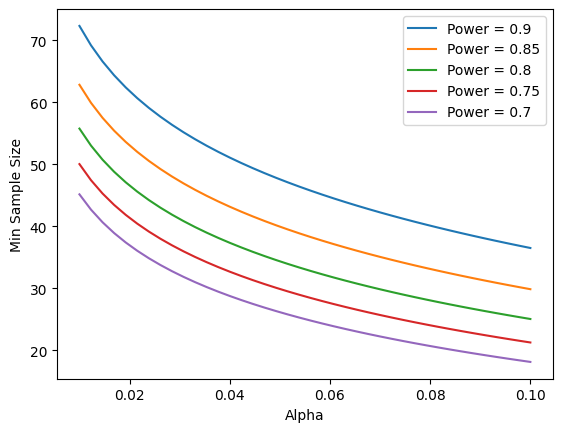

In [104]:
# Plot
for index, value in reversed(list(enumerate(power))):
    plt.plot(alpha, n[index], label=f'Power = {value}')
plt.xlabel('Alpha')
plt.ylabel('Min Sample Size')
plt.legend()
plt.show()

As expected, lower alphas (i.e. lower false positives) require more samples. Higher powers (i.e. lower false negatives) also require more samples.

### Metric Selection

So far we've used a simple conversion rate as the metric of choice. Metric selection can have a significant impact on the minimum sample size and study length. Let's examine this in a case study. 

### Case Study: Airbnb Landing Pages

Imagine Airbnb is considering a design change to their search landing page that is believed to lead to more searches and conversion rate increase by 1%. Let's consider two choices for the A/B test metric:
1. **Overall conversion rate:** Includes multiple steps/pages between the initial landing page and final booking confirmation page. Some users will drop out at each step.
2. **Percent of users performing a search:** The time between initial and final steps might be days or weeks as a user contemplates their options. Those performing a search may or may not come back to convert later.

Additional assumptions:
- Minimum detectable effect (MDE): 1%
- Baseline overall conversion rate: 0.2%
- Total unique visitors per month: 10 million
- Unique vistors reaching the search landing page: 20% or 2 million
- Alpha is 0.05 and power is 0.80 (typical values)

In [149]:
# Metric 1: Overall conversion rate
alpha = 0.05
power = 0.8
beta = 1 - power
one_tailed = True
mu0 = 0.002
mu1 = 1.01*mu0
sigma0 = mu0/2
sigma1 = sigma0

n = min_sample_size(alpha, beta, one_tailed, sigma0, sigma1, mu0, mu1)
print(f'Min sample size: {n:.1f}')

monthly_searches = 2e6
print(f'Time to complete: {n/monthly_searches:.2f} months')

Min sample size: 30912.8
Time to complete: 0.02 months


In [153]:
# Metric 2: Percent of users performing a search
alpha = 0.05
power = 0.8
beta = 1 - power
one_tailed = True
mu0 = 0.20
mu1 = 1.01*mu0
sigma0 = mu0/2
sigma1 = sigma0

n = min_sample_size(alpha, beta, one_tailed, sigma0, sigma1, mu0, mu1)
print(f'Min sample size: {n:.1f}')
monthly_searches = 2e6
print(f'Time to complete: {n/monthly_searches:.2f} months')

Min sample size: 30912.8
Time to complete: 0.02 months
